Establishing a connection with sqlite database

In [ ]:
# import pandas as pd
# import sqlite3

In [ ]:
# # def function to create connection to db
# def create_connection(db_file):
#     """
#     create a database connection to the SQLite database specified by db_file
#     :param df_file: database file
#     :return: Connection object or None
#     """
#     conn = None
#     try: 
#         conn = sqlite3.connect(db_file)
#         return conn
#     except 'Error' as e:
#         print(e)
        
#     return conn

In [ ]:
# # create connection to db
# conn = create_connection('s3://sagemaker-studio-520298385440-7in8n1t299/dublinbus.db')

In [ ]:
# # initialise query
# query = """
# SELECT leavetimes.*
# FROM leavetimes 
# WHERE TRIPID in  
#     (SELECT TRIPID
#     FROM trips
#     WHERE LINEID = '46A');
# """

In [ ]:
# # execute query and read into dataframe
# query_df = pd.read_sql(query, conn)

# 1. Model Preperation

In [1]:
# import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm

# from sagemaker import get_execution_role
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Connecting to s3
# role = get_execution_role()
# bucket='sagemaker-studio-520298385440-7in8n1t299'
# data_key = 'route_46a.feather'
# data_location = 's3://{}/{}'.format(bucket, data_key)

In [2]:
# Loading file
df = pd.read_feather('route_46a-Copy1.feather')

## 1.1. Reviewing, splitting dataset into 7:3 for training and testing.

In [3]:
df.head(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,969,43824,2018-01-01,Monday,January,5955567,15,334,2868381,37920,37840,37920,37840,0,-48195,-48394,1,1
1,970,43825,2018-01-01,Monday,January,5955567,16,406,2868381,38117,37913,38117,37922,9,197,73,1,1
2,971,43826,2018-01-01,Monday,January,5955567,17,747,2868381,38226,37983,38226,37983,0,109,61,1,1
3,972,43827,2018-01-01,Monday,January,5955567,18,842,2868381,38326,38047,38326,38047,0,100,64,1,1
4,973,43828,2018-01-01,Monday,January,5955567,19,845,2868381,38391,38079,38391,38079,0,65,32,1,1


In [4]:
df.tail(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
4347782,4346354,116750045,2018-12-31,Monday,December,8590439,5,811,2868385,69850,69740,69850,69801,61,47,59,0,1
4347783,4346355,116750046,2018-12-31,Monday,December,8590439,6,812,2868385,69874,69821,69874,69821,0,24,20,0,1
4347784,4346356,116750047,2018-12-31,Monday,December,8590439,7,813,2868385,69901,69842,69901,69871,29,27,21,0,1
4347785,4346357,116750048,2018-12-31,Monday,December,8590439,8,814,2868385,70007,69914,70007,69914,0,106,43,0,1
4347786,4346358,116750049,2018-12-31,Monday,December,8590439,9,81,2868385,70099,70057,70099,70083,26,92,143,0,1


In [5]:
# Missing values
df.isnull().sum()

level_0               0
index                 0
DAYOFSERVICE          0
DAYOFWEEK             0
MONTHOFSERVICE        0
TRIPID                0
PROGRNUMBER           0
STOPPOINTID           0
VEHICLEID             0
PLANNEDTIME_ARR       0
ACTUALTIME_ARR        0
PLANNEDTIME_DEP       0
ACTUALTIME_DEP        0
DWELLTIME             0
PLANNEDTIME_TRAVEL    0
ACTUALTIME_TRAVEL     0
IS_HOLIDAY            0
IS_WEEKDAY            0
dtype: int64

In [6]:
# Unique types for each feature
df.nunique()

level_0               4347787
index                 4347787
DAYOFSERVICE              360
DAYOFWEEK                   7
MONTHOFSERVICE             12
TRIPID                  23279
PROGRNUMBER                65
STOPPOINTID               126
VEHICLEID                 320
PLANNEDTIME_ARR         65347
ACTUALTIME_ARR          68077
PLANNEDTIME_DEP         65347
ACTUALTIME_DEP          68069
DWELLTIME                1278
PLANNEDTIME_TRAVEL       9586
ACTUALTIME_TRAVEL       13880
IS_HOLIDAY                  2
IS_WEEKDAY                  2
dtype: int64

In [7]:
# Datatypes and convert
df.dtypes

level_0                        int64
index                          int64
DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                     object
MONTHOFSERVICE                object
TRIPID                        object
PROGRNUMBER                   object
STOPPOINTID                   object
VEHICLEID                     object
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                    object
IS_WEEKDAY                    object
dtype: object

In [8]:
# Rows and columns
df.shape

(4347787, 18)

**Review so far:**
<br>
There are no more missing values and the constant columns have been removed.
* Remove index.
* Investigate level_0.
* Convert the following to categorical: DAYOFWEEK, MONTHOFSERVICE, PROGRNUMBER, STOPPOINTID, VEHICLEID, IS_HOLIDAY, IS_WEEKDAY.
* We have data for most of the days of the year and for each month.


In [9]:
df = df.drop(['level_0', 'index'], axis=1)

In [10]:
# Sorting by trip then dayofservice
df = df.sort_values(by=['TRIPID', 'DAYOFSERVICE'])

In [11]:
# Creating features
categorical_features = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 
                       'IS_HOLIDAY', 'IS_WEEKDAY', 'TRIPID', 'VEHICLEID']

datetime_features = ['DAYOFSERVICE']

numerical_features = ['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP',
                     'DWELLTIME', 'PLANNEDTIME_TRAVEL']

target_feat = 'ACTUALTIME_TRAVEL'

In [12]:
# Converting object to categorical
for column in categorical_features:
    df[column] = df[column].astype('category')

In [19]:
# Replacing PROGRNUMBER equal to 1 of ACTUALTIME_TRAVEL with 0
df.loc[df['PROGRNUMBER'] == '1', 'ACTUALTIME_TRAVEL'] = 0

In [23]:
df.loc[df['PROGRNUMBER']=='1']

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
153,2018-05-02,Wednesday,May,6662750,1,807,2534808,41760,41824,41760,41824,0,-4152,0,0,1
177,2018-12-03,Monday,December,8149976,1,807,2172281,76500,76504,76500,76504,0,1740,0,0,1
179,2018-09-10,Monday,September,8085187,1,807,1930278,25920,25957,25920,25957,0,-41978,0,0,1
240,2018-03-16,Friday,March,6401454,1,2039,1000281,52560,52539,52560,52539,0,-4838,0,0,1
260,2018-07-17,Tuesday,July,7182236,1,807,1000580,59760,59795,59760,59795,0,-4641,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347494,2018-08-22,Wednesday,August,7327499,1,807,1000566,45720,45655,45720,45655,0,-3808,0,0,1
4347518,2018-01-08,Monday,January,6102775,1,807,1000296,36960,36968,36960,36968,0,6420,0,0,1
4347555,2018-08-06,Monday,August,7315427,1,2039,2406876,83400,83489,83400,83489,0,-1727,0,1,1
4347739,2018-12-24,Monday,December,8576937,1,2039,1932341,50400,50514,50400,50514,0,1124,0,0,1


In [ ]:
# # Converting numerical to timedelta
# for column in numerical_features:
#     df[column] = df[column].apply(pd.to_timedelta, unit='s')

In [ ]:
# df['ACTUALTIME_TRAVEL'] = df['ACTUALTIME_TRAVEL'].apply(pd.to_timedelta, unit='s')

In [20]:
df.dtypes

DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                   category
MONTHOFSERVICE              category
TRIPID                      category
PROGRNUMBER                 category
STOPPOINTID                 category
VEHICLEID                   category
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                  category
IS_WEEKDAY                  category
dtype: object

<br><br>
Setting the target feature as _y and x_ as the remaining features in the dataframe. 
<br><br>

In [21]:
df = df.sample(frac=1).reset_index(drop=True)

In [22]:
df.head(20)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,2018-02-16,Friday,February,6262176,31,763,1000278,39468,39768,39468,39768,0,53,64,0,1
1,2018-01-02,Tuesday,January,5958130,64,807,1000558,43217,42821,43217,42821,0,53,65,0,1
2,2018-04-27,Friday,April,6633869,19,845,2172241,64256,64138,64256,64138,0,74,50,0,1
3,2018-03-17,Saturday,March,6399025,20,2063,1000266,31406,31707,31406,31719,12,37,30,1,0
4,2018-04-11,Wednesday,April,6622311,44,786,1000566,66229,66294,66229,66381,87,63,36,0,1
5,2018-08-15,Wednesday,August,7322632,50,4565,3265671,47937,48605,47937,48605,0,93,106,0,1
6,2018-05-12,Saturday,May,6749326,50,4565,2406890,30753,30843,30753,30854,11,81,48,0,0
7,2018-02-12,Monday,February,6254122,7,813,2406882,28296,28314,28296,28342,28,55,27,0,1
8,2018-07-07,Saturday,July,7135764,23,4727,2868331,32867,32826,32867,32848,22,93,49,0,0
9,2018-10-08,Monday,October,8015519,54,797,1930279,67856,68484,67856,68493,9,126,141,0,1


In [24]:
# Creating y and x axis
target_feature = df['ACTUALTIME_TRAVEL']
y = pd.DataFrame(target_feature)
X = df.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("The test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The original range is:  4347787
The training range (70%):	 rows 0 to 3043450
The test range (30%): 	 rows 3043450 to 4347787


In [25]:
X_train.head(5)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
2296641,2018-05-16,Wednesday,May,6753802,58,2036,2172285,26664,27092,26664,27092,0,57,0,1
1261342,2018-04-19,Thursday,April,6636913,44,2017,1932337,32129,33016,32129,33031,15,32,0,1
2777787,2018-10-30,Tuesday,October,8069040,59,2039,1932341,29821,28366,29821,28366,0,45,0,1
1107681,2018-07-06,Friday,July,7145636,42,908,1000586,66072,66599,66072,66631,32,47,0,1
2419838,2018-03-15,Thursday,March,6396730,14,6059,1000566,51897,52720,51897,52822,102,152,0,1


## 1.2. Plot to compare all features to target feature to help make decisions to keep for the models.

#### Plotting datetime feature against target feature

In [26]:
# Plot datetime feature against target feature
X_train.DAYOFSERVICE = pd.to_numeric(X_train.DAYOFSERVICE)
df_temp = pd.concat([X_train['DAYOFSERVICE'], y_train], axis=1)
correlation_dt = df_temp[['DAYOFSERVICE', 'ACTUALTIME_TRAVEL']].corr(method='pearson')
correlation_dt

,DAYOFSERVICE,ACTUALTIME_TRAVEL
DAYOFSERVICE,1.000000,0.003806
ACTUALTIME_TRAVEL,0.003806,1.000000


<AxesSubplot:xlabel='DAYOFSERVICE', ylabel='ACTUALTIME_TRAVEL'>

<Figure size 432x288 with 0 Axes>

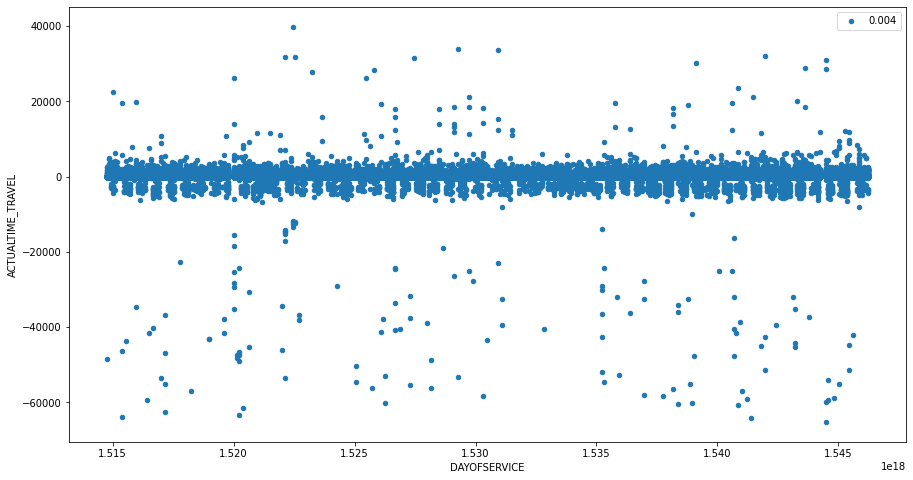

In [27]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='DAYOFSERVICE', y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', 'DAYOFSERVICE']].corr().to_numpy()[0,1], figsize=(15, 8)) 

#### Plotting numerical features against target feature

In [28]:
# # Plot numerical features against target feature

# sns.set(style='white')

# # Calculating the correlation of all pairs of the numerical features
# corr = X_train[numerical_features].corr()

# # Generating a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up matplotlib figure
# f, ax = plt.subplots(figsize=(20,20))

# # Generating a custome color map
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
#             square=True, xticklabels=True, yticklabels=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# plt.yticks(rotation = 0)
# plt.xticks(rotation = 90)

In [29]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='pearson')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000           0.001271
ACTUALTIME_TRAVEL         0.001271           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000           0.002139
ACTUALTIME_TRAVEL        0.002139           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000           0.001271
ACTUALTIME_TRAVEL         0.001271           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000           0.002209
ACTUALTIME_TRAVEL        0.002209           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.037774
ACTUALTIME_TRAVEL   0.037774           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL             1.00000            0.24427
ACTUALTIME_TRAVEL              0.24427            1.00000


Using pearson correlation, we see that the correlation between 

In [30]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='spearman')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.052938
ACTUALTIME_TRAVEL        -0.052938           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.051075
ACTUALTIME_TRAVEL       -0.051075           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.052938
ACTUALTIME_TRAVEL        -0.052938           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.050707
ACTUALTIME_TRAVEL       -0.050707           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.350892
ACTUALTIME_TRAVEL   0.350892           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.749339
ACTUALTIME_TRAVEL             0.749339           1.000000


<Figure size 432x288 with 0 Axes>

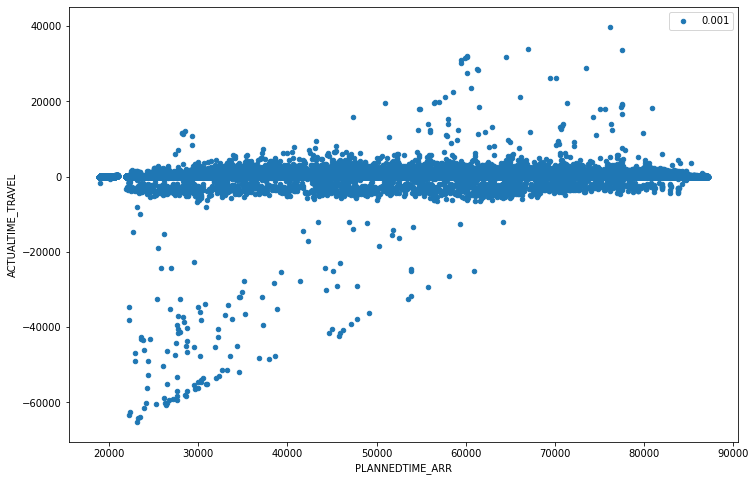

<Figure size 432x288 with 0 Axes>

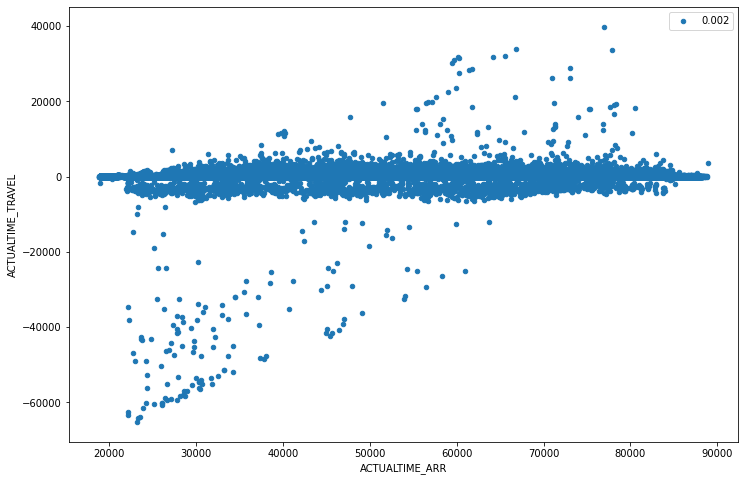

<Figure size 432x288 with 0 Axes>

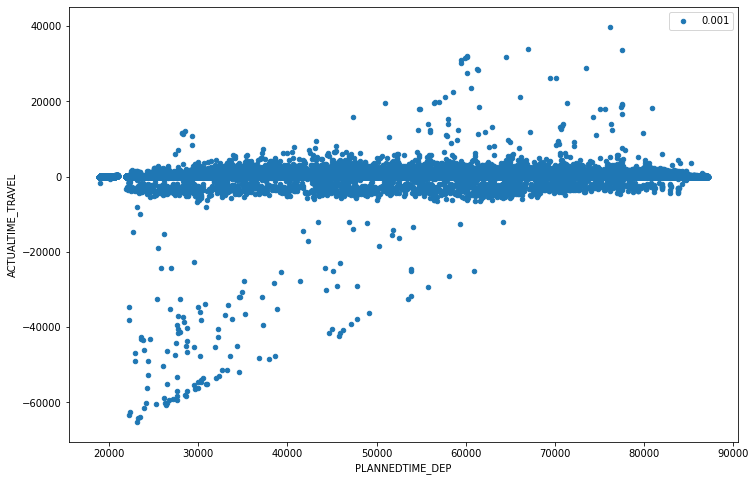

<Figure size 432x288 with 0 Axes>

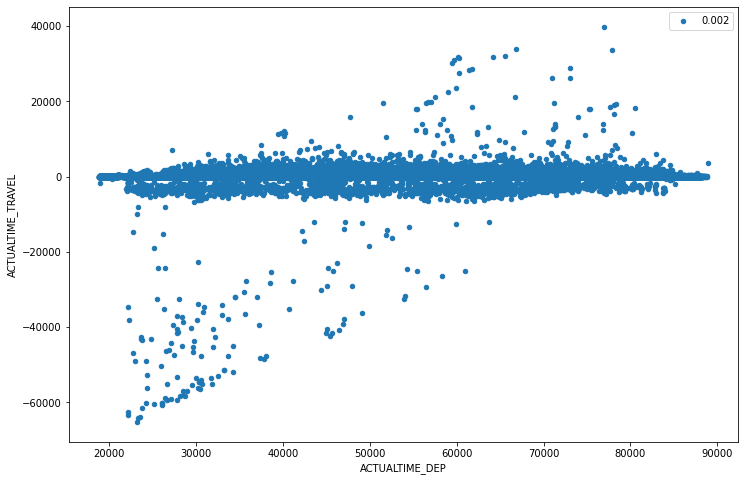

<Figure size 432x288 with 0 Axes>

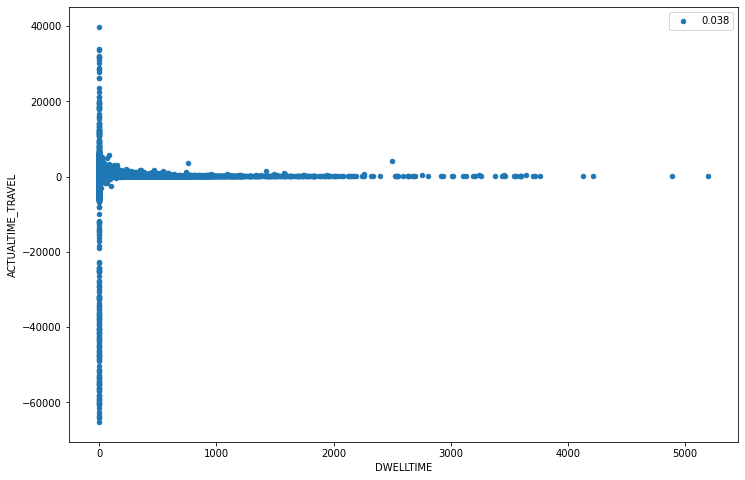

<Figure size 432x288 with 0 Axes>

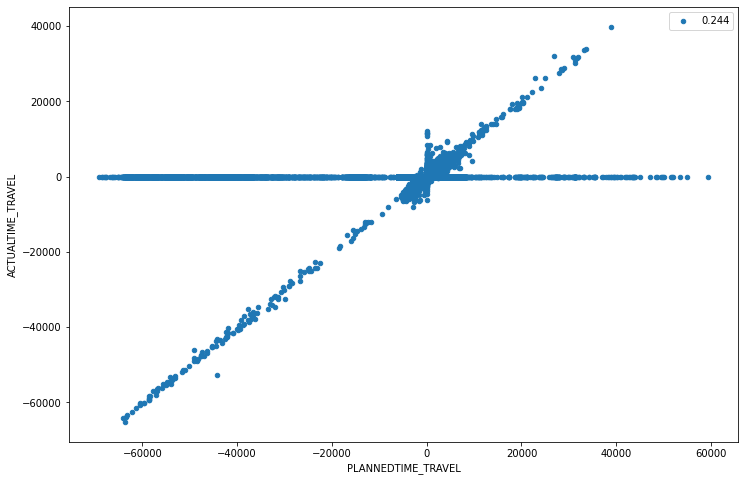

In [31]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='pearson').to_numpy()[0,1], figsize=(12, 8)) 

<Figure size 432x288 with 0 Axes>

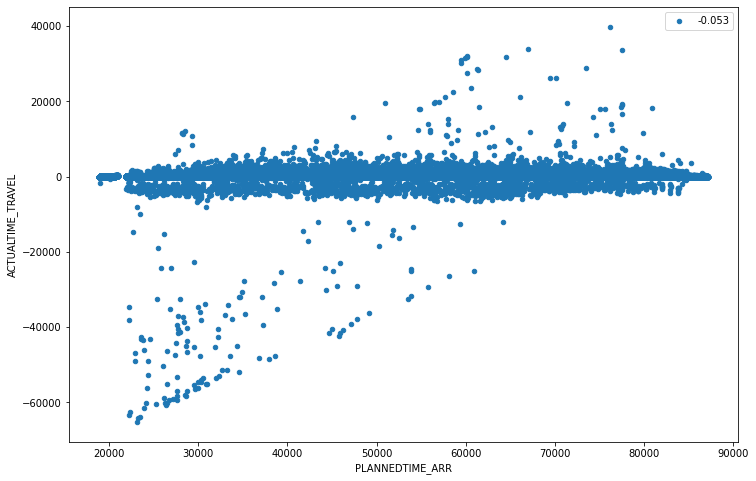

<Figure size 432x288 with 0 Axes>

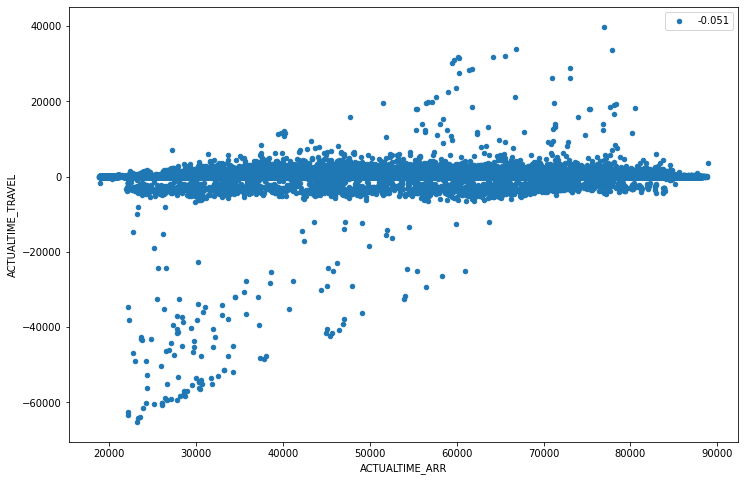

<Figure size 432x288 with 0 Axes>

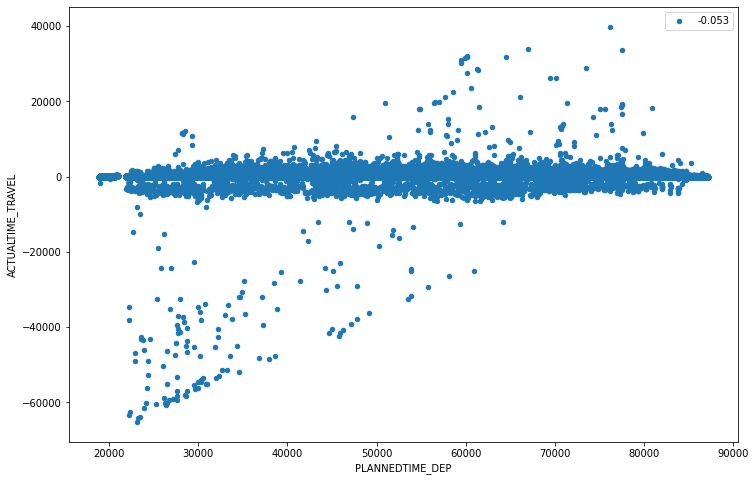

<Figure size 432x288 with 0 Axes>

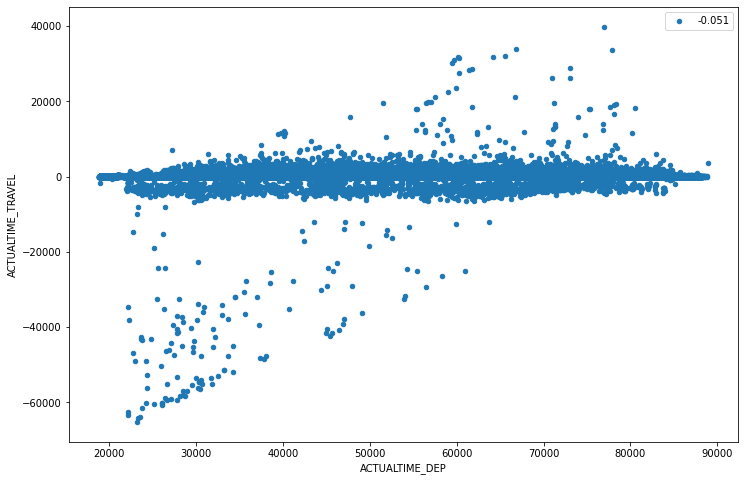

<Figure size 432x288 with 0 Axes>

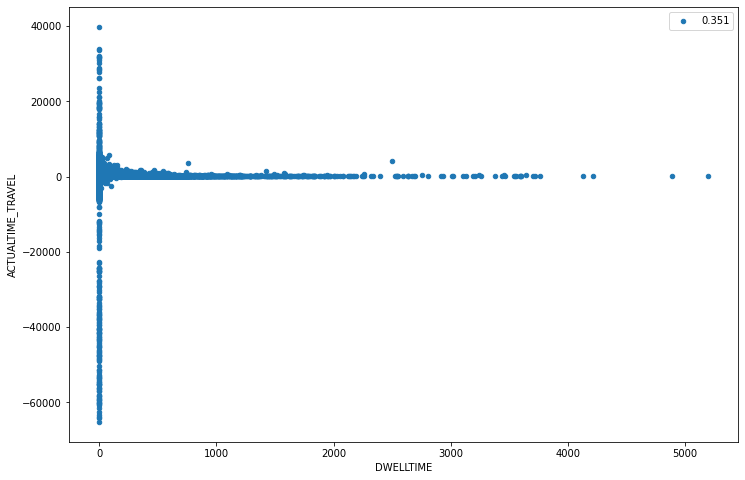

<Figure size 432x288 with 0 Axes>

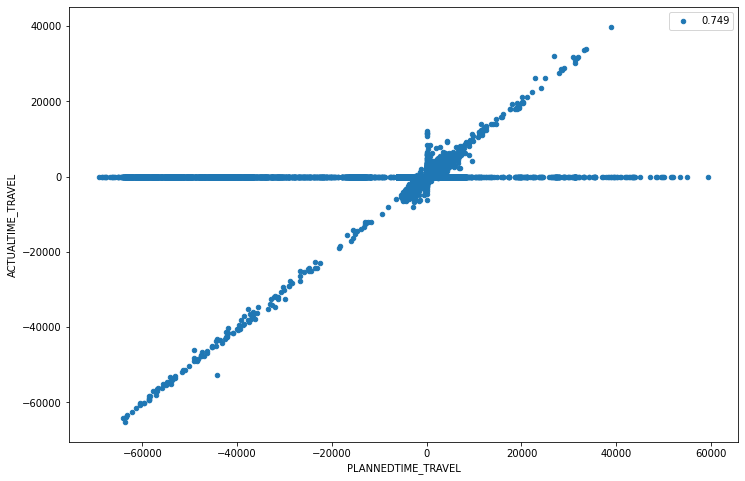

In [32]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

#### Plotting categorical features against target feature

In [33]:
# # Finding the average between some categorical
# year_features = ['DAYOFWEEK', 'IS_HOLIDAY', 'IS_WEEKDAY', 'MONTHOFSERVICE']
# df_temp = pd.concat([X_train, y_train], axis=1)

# for feature in year_features:
#     categ_feat = pd.unique(df_temp[feature].ravel())
#     df_temp['percent'] = 0
    
#     print("\n", feature)
#     print("Index \t\t Count")
    
#     for c in categ_feat:
#         count = df_temp[df_temp[feature] == c].count()['ACTUALTIME_TRAVEL']
#         count_percentage = (1/count) * 100
#         df_temp.loc[df_temp[feature] == c, 'percent'] = count_percentage
#         print(c, "\t", count)
        
#     grouped = df_temp[['percent', feature, 'ACTUALTIME_TRAVEL']].groupby([feature, 'ACTUALTIME_TRAVEL']).sum()
#     plot = grouped.unstack().plot(kind='bar', stacked=True, title=f' ACTUALTIME_TRAVEL vs {feature}', figsize=(10,5), grid=True)
    
#     # Adding legends
#     red = mpatches.Patch(color='orange', label='Yes')
#     blue = mpatches.Patch(color='blue', label='No')
#     plot.legend(handles=[red, blue], frameon = True)
    
#     # Adding gridlines
#     plt.grid(b=True, which='major', color='#666666', linestyle='-')
#     plt.minorticks_on()
#     plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
#     # Adding labels
#     # add labels
#     # add labels
#     plot.set_xlabel("---")
#     plot.set_ylabel("% ACTUALTIME")
#     plot.set_ylim([0,100])
    
# # drop 'percent' that was used only for stacked bar plot
# df_temp = df_temp.drop("percent", 1)

DAYOFWEEK


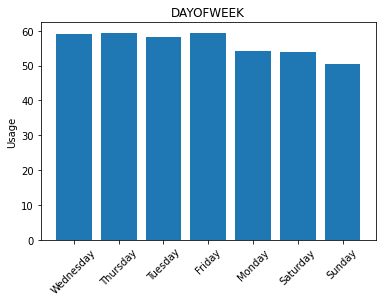

IS_HOLIDAY


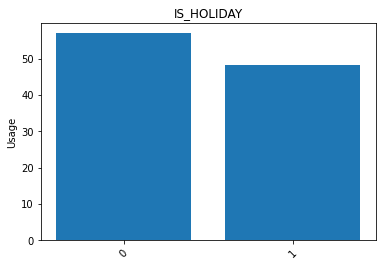

IS_WEEKDAY


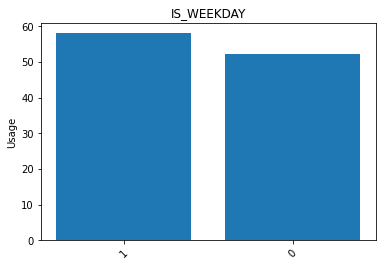

MONTHOFSERVICE


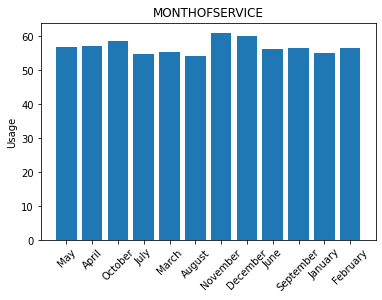

In [48]:
year_features = ['DAYOFWEEK', 'IS_HOLIDAY', 'IS_WEEKDAY', 'MONTHOFSERVICE']

for feature in year_features:
    print(feature)
    df_temp = pd.concat([X_train, y_train], axis=1)
    unique = df_temp[feature].unique()
    list_average = []
    
    for value in unique:
        list_values = df_temp[df_temp[feature]== value]['ACTUALTIME_TRAVEL'].tolist()
        length_list = len(list_values)
        average =  sum(list_values)/length_list
        list_average += [average]
#         print(f'Sum of values / list of values: \n {sum(list_values)} / {length_list}')
#         print(f'Average ACTUALTIME_TRAVEL: {average}, \n')
        
    # taken from https://pythonspot.com/matplotlib-bar-chart/
    y_pos = np.arange(len(unique))
    plt.bar(y_pos, list_average, align='center')
    plt.xticks(y_pos, unique)
    plt.ylabel('Usage')
    plt.title(feature)
    plt.xticks(rotation=45)

    plt.show()

I think there is some outliers in ACTUALTME_TRAVEL. The averages are all in negatives which suggests that the travel times. Would that be an outlier if the negative values are very great? 
<br><br>
**DAYOFWEEK:**
The lowest average is Sunday and the busiest is Monday. So it does make a difference.
<br><br>
**IS_WEEKDAY:**
The same comment that there is a difference in average times.
<br><br>
**MONTHOFSERVICE:**
Interestingly enough, they have difference averages depending on each month with August being the least busiest and April being the busiest. It must have something to do with the weather maybe?


In [35]:
# Average time for each vehicle id
df_temp = pd.concat([X_train, y_train], axis=1)
vehicleid = df_temp['VEHICLEID'].unique().tolist()
for id_ in vehicleid:
    print(f'VEHICLEID: {id_}')
    list_values = df_temp[df_temp['VEHICLEID']== id_]['ACTUALTIME_TRAVEL'].tolist()
    length_list = len(list_values)
    average =  sum(list_values)/length_list
    print(f'Average ACTUALTIME_TRAVEL: {average} \n')

VEHICLEID: 2172285
Average ACTUALTIME_TRAVEL: 54.44695161640269 

VEHICLEID: 1932337
Average ACTUALTIME_TRAVEL: 57.488339131555215 

VEHICLEID: 1932341
Average ACTUALTIME_TRAVEL: 51.5219795722589 

VEHICLEID: 1000586
Average ACTUALTIME_TRAVEL: 53.43565395571993 

VEHICLEID: 1000566
Average ACTUALTIME_TRAVEL: 55.727464489240454 

VEHICLEID: 1000574
Average ACTUALTIME_TRAVEL: 58.156480286026415 

VEHICLEID: 2868334
Average ACTUALTIME_TRAVEL: 55.25703977472721 

VEHICLEID: 1000578
Average ACTUALTIME_TRAVEL: 59.22688093164 

VEHICLEID: 1000266
Average ACTUALTIME_TRAVEL: 56.88341413304017 

VEHICLEID: 2868385
Average ACTUALTIME_TRAVEL: 54.61600507522204 

VEHICLEID: 1000272
Average ACTUALTIME_TRAVEL: 56.771984834511734 

VEHICLEID: 1000556
Average ACTUALTIME_TRAVEL: 60.83221050962987 

VEHICLEID: 1000281
Average ACTUALTIME_TRAVEL: 59.152241405421776 

VEHICLEID: 1000560
Average ACTUALTIME_TRAVEL: 56.40069680657838 

VEHICLEID: 1000576
Average ACTUALTIME_TRAVEL: 59.70429337721454 

VEHICLEID

Average ACTUALTIME_TRAVEL: 59.96666666666667 

VEHICLEID: 1932339
Average ACTUALTIME_TRAVEL: 60.903475142221126 

VEHICLEID: 1932302
Average ACTUALTIME_TRAVEL: 57.71765064216458 

VEHICLEID: 3265667
Average ACTUALTIME_TRAVEL: 49.062098501070665 

VEHICLEID: 2693277
Average ACTUALTIME_TRAVEL: 45.37462913960388 

VEHICLEID: 3265669
Average ACTUALTIME_TRAVEL: 53.27470315958946 

VEHICLEID: 3265666
Average ACTUALTIME_TRAVEL: 52.82888130146616 

VEHICLEID: 2172280
Average ACTUALTIME_TRAVEL: 55.01649618210632 

VEHICLEID: 3265701
Average ACTUALTIME_TRAVEL: 53.596954769368566 

VEHICLEID: 1932301
Average ACTUALTIME_TRAVEL: 58.7449397899052 

VEHICLEID: 2693224
Average ACTUALTIME_TRAVEL: 45.4306430228704 

VEHICLEID: 1932300
Average ACTUALTIME_TRAVEL: 59.404010025062654 

VEHICLEID: 3370456
Average ACTUALTIME_TRAVEL: 52.003389830508475 

VEHICLEID: 1001240
Average ACTUALTIME_TRAVEL: 55.96774193548387 

VEHICLEID: 2534805
Average ACTUALTIME_TRAVEL: 57.41165695253955 

VEHICLEID: 2868381
Average

Average ACTUALTIME_TRAVEL: 62.12162162162162 

VEHICLEID: 2534827
Average ACTUALTIME_TRAVEL: 62.6530612244898 

VEHICLEID: 2693250
Average ACTUALTIME_TRAVEL: 65.30275229357798 

VEHICLEID: 1001122
Average ACTUALTIME_TRAVEL: 60.57446808510638 

VEHICLEID: 1000480
Average ACTUALTIME_TRAVEL: 49.529411764705884 

VEHICLEID: 1001191
Average ACTUALTIME_TRAVEL: 54.06666666666667 

VEHICLEID: 1000718
Average ACTUALTIME_TRAVEL: 58.825 

VEHICLEID: 1001199
Average ACTUALTIME_TRAVEL: 74.53846153846153 

VEHICLEID: 1000851
Average ACTUALTIME_TRAVEL: 55.0 

VEHICLEID: 3393870
Average ACTUALTIME_TRAVEL: 55.9 

VEHICLEID: 1932318
Average ACTUALTIME_TRAVEL: 66.32075471698113 

VEHICLEID: 2406911
Average ACTUALTIME_TRAVEL: 71.73684210526316 

VEHICLEID: 1001188
Average ACTUALTIME_TRAVEL: 78.35 

VEHICLEID: 1001192
Average ACTUALTIME_TRAVEL: 82.04761904761905 

VEHICLEID: 2693194
Average ACTUALTIME_TRAVEL: 69.60714285714286 

VEHICLEID: 2693195
Average ACTUALTIME_TRAVEL: 67.84444444444445 

VEHICLEID: 1